In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras

path = "/content/drive/MyDrive/msc-data-science-23-24/csc8628-image-informatics/"

batch_size = None
image_size = (256, 256)
interpolation = 'nearest'

img_data = keras.utils.image_dataset_from_directory(
    path + "Assignment Dataset/Images/img_dir",
    labels=None,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
    interpolation=interpolation
)

ann_data = keras.utils.image_dataset_from_directory(
    path + "Assignment Dataset/Images/ann_dir",
    labels=None,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
    interpolation=interpolation
)

Found 2135 files belonging to 1 classes.
Found 2135 files belonging to 1 classes.


In [ ]:
import numpy as np

img_np = np.array(list(img_data.as_numpy_iterator())).astype("uint8")
ann_np = np.array(list(ann_data.as_numpy_iterator())).astype("uint8")

In [ ]:
print(f'img shape: {img_np.shape}')
print(f'ann shape: {ann_np.shape}')

img shape: (2135, 256, 256, 3)
ann shape: (2135, 256, 256, 3)


In [ ]:
# !pip install -U scikit-image~=0.22

In [ ]:
import skimage
print(skimage.__version__)

0.22.0


In [ ]:
def label_segment_image(y_truth, y_pred, final_shape=(256, 256, 3)):
  y_truth = y_truth.copy()
  y_pred = y_pred.copy()

  ## Convert to 2D representation
  y_truth_2d = y_truth.reshape((-1, y_truth.shape[-1]))
  y_pred_2d = y_pred.reshape((-1, y_pred.shape[-1]))

  ## Retrieve the unique values and indices occurrences
  yt_unique_rows, yt_indices = np.unique(y_truth_2d, axis=0, return_index=True)
  yp_unique_rows, yp_indices = np.unique(y_pred_2d, axis=0, return_index=True)

  print(f'yt_unique_rows: {yt_unique_rows}')
  print(f'yp_unique_rows: {yp_unique_rows}')
  print(f'yt_indices: {yt_indices}')
  print(f'yp_indices: {yp_indices}')

  ## Correspond the yt_indices to the y_pred_2d and change that position unique
  ## value (all of it) of y_pred_2d to correspond to the yt_unique_rows value
  ## corresponding to the yt_indices
  for yt_row, yt_index in zip(yt_unique_rows, yt_indices):
    ## Find all the index position of all values of y_pred_2d that matches
    ## the value in the y_pred_2d[yt_index]
    yp_replace_indices = np.all(y_pred_2d == y_pred_2d[yt_index], axis=1)

    print(f'yt_row: {yt_row}')
    print(f'yt_index: {yt_index}')
    y_pred_2d[yp_replace_indices] = yt_row

  ## Return the changed numpy image (reshaped back to normal shape)
  return y_pred_2d.reshape(final_shape)

In [ ]:
# from skimage import data, segmentation, filters, color, graph
# from matplotlib import pyplot as plt


# def weight_boundary(graph, src, dst, n):
#     """
#     Handle merging of nodes of a region boundary region adjacency graph.

#     This function computes the `"weight"` and the count `"count"`
#     attributes of the edge between `n` and the node formed after
#     merging `src` and `dst`.


#     Parameters
#     ----------
#     graph : RAG
#         The graph under consideration.
#     src, dst : int
#         The vertices in `graph` to be merged.
#     n : int
#         A neighbor of `src` or `dst` or both.

#     Returns
#     -------
#     data : dict
#         A dictionary with the "weight" and "count" attributes to be
#         assigned for the merged node.

#     """
#     default = {'weight': 0.0, 'count': 0}

#     count_src = graph[src].get(n, default)['count']
#     count_dst = graph[dst].get(n, default)['count']

#     weight_src = graph[src].get(n, default)['weight']
#     weight_dst = graph[dst].get(n, default)['weight']

#     count = count_src + count_dst
#     return {
#         'count': count,
#         'weight': (count_src * weight_src + count_dst * weight_dst)/count
#     }


# def merge_boundary(graph, src, dst):
#     """Call back called before merging 2 nodes.

#     In this case we don't need to do any computation here.
#     """
#     pass

# def image_segmentation(image):
#   img = image.copy()
#   img_gray = color.rgb2gray(img)
#   edges = filters.sobel(img_gray)

#   labels = segmentation.slic(img, slic_zero=True)
#   # labels = segmentation.felzenszwalb(img)
#   g = graph.rag_boundary(labels, edges)

#   # graph.show_rag(labels, g, img)
#   # plt.title('Initial RAG')

#   labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
#                                     in_place_merge=True,
#                                     merge_func=merge_boundary,
#                                     weight_func=weight_boundary)

#   # graph.show_rag(labels, g, img)
#   # plt.title('RAG after hierarchical merging')
#   # plt.figure()

#   out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
#   boundary_out = segmentation.mark_boundaries(out, labels2, color=(0, 0, 0))

#   # return out
#   return boundary_out


# Image Segmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, color, graph, segmentation


def image_segmentation(image):
  img = image.copy()

  labels = segmentation.slic(img, convert2lab=True, sigma=1.4, slic_zero=True)
  out = color.label2rgb(labels, img, kind='avg', bg_label=0)

  rag = graph.rag_mean_color(img, labels, mode='similarity', sigma=400)

  new_labels = graph.cut_normalized(labels, rag, rng=200)

  segments = segmentation.mark_boundaries(out, new_labels, color=(0, 0, 0))

  out = segmentation.mark_boundaries(img, new_labels, color=(0, 0, 0))

  print(np.unique(new_labels, return_index=True))
  print(new_labels.shape)

  graph.show_rag(labels, rag, img)
  plt.show()

  plt.imshow(new_labels)
  plt.show()

  plt.imshow(segments)
  plt.show()

  return out, new_labels

rand: 0
(array([ 1,  3,  8, 20, 25, 52, 69, 99]), array([    0,    56,   180,  8665, 12948, 31050, 41953, 61569]))
(256, 256)


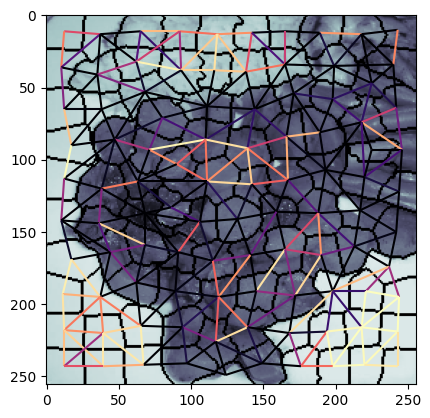

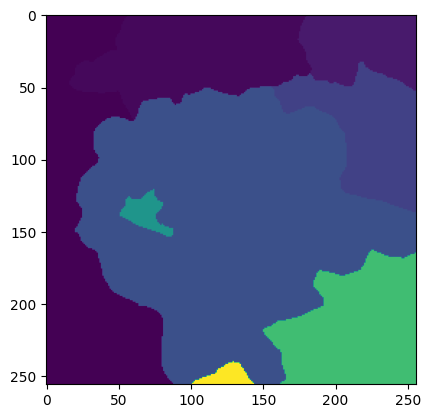

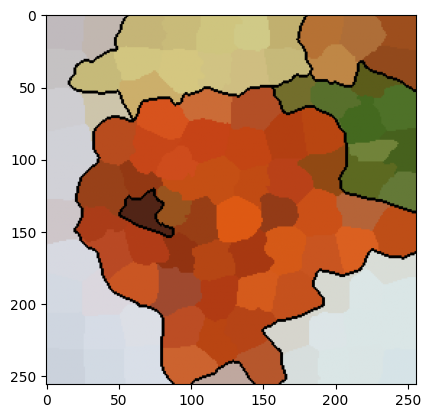

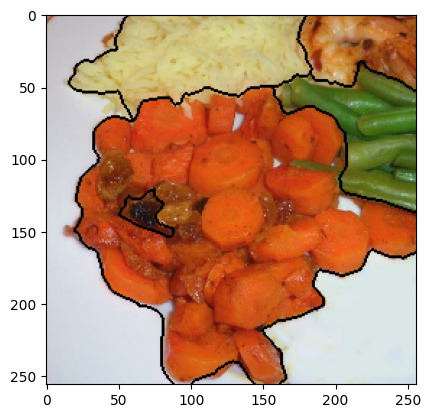

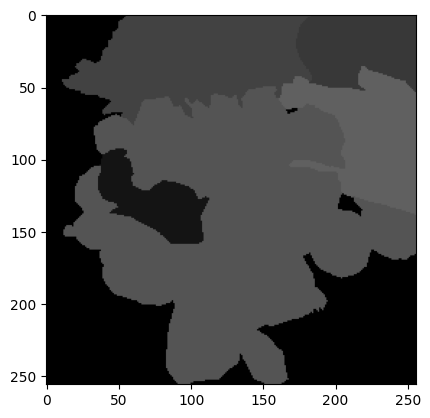

In [163]:
import random

# rand = random.randrange(0, len(img_np))
rand = 0
print(f'rand: {rand}')

input = img_np[rand].copy()

out, _ = image_segmentation(input)

plt.imshow(out)
plt.show()

plt.imshow(ann_np[rand].copy(), cmap='gray')
plt.show()

In [112]:
def gray_histogram_channels(x):
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    p = plt.imshow(x, cmap="gray")
    t = ax.axis("off")

    v = np.concatenate(x)
    bins = np.linspace(np.min(x), np.max(x), 50)

    ax = fig.add_subplot(2, 1, 2)
    p = plt.hist(v, bins,color='k', histtype='step')
    p = plt.legend(loc='upper right')
    p = plt.title("Gray Histogram")
    p = plt.xlabel('Intensity')
    p = plt.ylabel('Frequency')
    p = plt.show()

    fig.tight_layout()

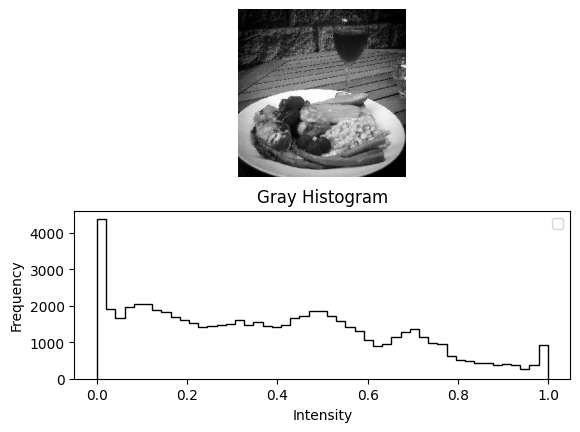

In [115]:
# gray_histogram_channels(color.rgb2gray(input))

[0.         0.05490196 0.12941176 0.18823529 0.19215686 0.23137255
 0.33333333]


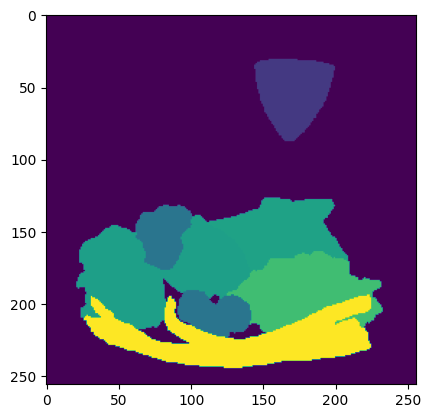

In [ ]:
# plt.imshow(color.rgb2gray(ann_np[rand]))
# print(np.unique(color.rgb2gray(ann_np[rand])))

In [129]:
# import numpy as np

# # Sample image
# image = np.array([
#     [56, 56, 56], [23, 45, 78], [12, 90, 100],
#     [56, 56, 56], [89, 10, 20], [34, 56, 78],
#     [78, 90, 100], [56, 56, 56], [56, 78, 90]
# ])

# # image = ann_np[0].copy()

# print(f'image shape: {image.shape}')

# # Target value for all channels
# target_value = [56, 56, 56]

# # Create a mask to identify desired values
# mask = (image == target_value).all(axis=-1)
# # mask = np.any(image == target_value, axis=-1)

# print(f'mask: {mask}')

# # Filter the image using the mask
# filtered_image = image[mask]

# # Print the filtered image
# print(filtered_image)

# # Find indices of all True values using .nonzero()
# true_indices = np.nonzero(mask)

# # Print the indices
# print(f'mask indices: {true_indices}')

# # Calculate the midpoint index (assuming even length)
# midpoint_index = len(true_indices[0]) // 2

# print(f"Middle element in true_indices: {true_indices[0][midpoint_index]}")

image shape: (9, 3)
mask: [ True False False  True False False False  True False]
[[56 56 56]
 [56 56 56]
 [56 56 56]]
mask indices: (array([0, 3, 7]),)
Middle element in true_indices: 3


In [140]:
# import numpy as np

# # Sample image with shape (4, 4, 3)
# image = np.array([
#     [[56, 56, 56], [23, 45, 78], [56, 56, 56], [12, 90, 100]],
#     [[56, 56, 56], [89, 10, 20], [56, 56, 56], [34, 56, 78]],
#     [[78, 90, 100], [56, 56, 56], [56, 78, 90], [56, 56, 56]],
#     [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
# ])

# # Target value for all channels
# target_value = [56, 56, 56]

# # Create a mask to identify rows with desired values
# mask = np.all(image == target_value, axis=-1)

# # Print the mask
# print("Mask:")
# print(mask)

# # Filter the image using the mask
# filtered_rows = image[mask]

# # Print the rows with desired values
# print("\nRows with desired values:")
# print(filtered_rows)

# # Find indices of all True values using .nonzero()
# true_indices = np.nonzero(mask.flatten())

# # Print the indices
# print(f'mask indices: {true_indices}')

# # Calculate the midpoint index (assuming even length)
# midpoint_index = len(true_indices[0]) // 2

# print(f"Middle element in true_indices: {true_indices[0][midpoint_index]}")

Mask:
[[ True False  True False]
 [ True False  True False]
 [False  True False  True]
 [False False False False]]

Rows with desired values:
[[56 56 56]
 [56 56 56]
 [56 56 56]
 [56 56 56]
 [56 56 56]
 [56 56 56]]
mask indices: (array([ 0,  2,  4,  6,  9, 11]),)
Middle element in true_indices: 6


In [154]:
# import numpy as np

# # Sample image with shape (4, 4, 3)
# image = np.array([
#     [[56, 56, 56], [23, 45, 78], [56, 56, 56], [12, 90, 100]],
#     [[56, 56, 56], [89, 10, 20], [56, 56, 56], [34, 56, 78]],
#     [[78, 90, 100], [56, 56, 56], [56, 78, 90], [56, 56, 56]],
#     [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
# ])

# # Target value for all channels
# target_value = [56, 56, 56]

# # Create a mask to identify rows with desired values
# mask = np.all(image == target_value, axis=-1)

# # Get indices of True values in the mask
# indices = np.where(mask)

# # Print the indices
# print("\nIndices of True values:")
# print(indices)

# # Use indices to retrieve values from the original image array
# target_values_in_image = image[indices[0], indices[1]]

# # Print the corresponding values
# print("\nCorresponding values in the image array:")
# print(target_values_in_image)


Indices of True values:
(array([0, 0, 1, 1, 2, 2]), array([0, 2, 0, 2, 1, 3]))

Corresponding values in the image array:
[[56 56 56]
 [56 56 56]
 [56 56 56]
 [56 56 56]
 [56 56 56]
 [56 56 56]]


In [156]:
# import numpy as np

# # Sample image with shape (4, 4, 3)
# image = np.array([
#     [[56, 56, 56], [23, 45, 78], [56, 56, 56], [12, 90, 100]],
#     [[56, 56, 56], [89, 10, 20], [56, 56, 56], [34, 56, 78]],
#     [[78, 90, 100], [56, 56, 56], [56, 78, 90], [56, 56, 56]],
#     [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]],
#         [[56, 56, 56], [23, 45, 78], [56, 56, 56], [12, 90, 100]],
#     [[56, 56, 56], [89, 10, 20], [56, 56, 56], [34, 56, 78]],
#     [[78, 90, 100], [56, 56, 56], [56, 78, 90], [56, 56, 56]],
#     [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
# ])

# # Target value for all channels
# target_value = [56, 56, 56]

# # Create a mask to identify rows with desired values
# mask = np.all(image == target_value, axis=-1)

# # Get indices of True values in the mask
# indices = np.where(mask)

# # Print the indices
# print("\nIndices of True values:")
# print(indices)

# # Calculate the middle index (assuming even length)
# middle_index = len(indices[0]) // 2

# # Use the middle index to retrieve the corresponding value from the original image array
# middle_value_in_image = image[indices[0][middle_index], indices[1][middle_index]]

# # Print the corresponding value
# print("\nCorresponding middle value in the image array:")
# print(middle_value_in_image)


Indices of True values:
(array([0, 0, 1, 1, 2, 2, 4, 4, 5, 5, 6, 6]), array([0, 2, 0, 2, 1, 3, 0, 2, 0, 2, 1, 3]))

Corresponding middle value in the image array:
[56 56 56]


In [149]:
for i in true_indices[0]:
  print(image.f[i])

[56 56 56]
[56 56 56]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [153]:
# print(image[0])

[[ 56  56  56]
 [ 23  45  78]
 [ 56  56  56]
 [ 12  90 100]]


In [ ]:
# import cv2 as cv
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import filters

# img = img_np[0].copy()
# img_enhance = cv.detailEnhance(img)
# img_sobel = filters.sobel(color.rgb2gray(img))
# img_enhance_sobel = filters.sobel(color.rgb2gray(img_enhance))
# # img_laplace = filters.laplace(img)
# # img_enhance_laplace = filters.laplace(img_enhance)
# img_laplace = cv.Laplacian(img, ddepth=cv.CV_64F)
# img_enhance_laplace = cv.Laplacian(img_enhance, ddepth=cv.CV_64F)
# img_edge_preserve = cv.edgePreservingFilter(img)
# img_enhance_edge_preserve = cv.edgePreservingFilter(img_enhance)
# img_edge_preserve_norm = cv.edgePreservingFilter(img, flags=cv.NORMCONV_FILTER)
# img_enhance_edge_preserve_norm = cv.edgePreservingFilter(img_enhance, flags=cv.NORMCONV_FILTER)


# # Image
# plt.imshow(img)
# plt.show()

# plt.imshow(img_enhance)
# plt.show()

# # Sobel edges
# plt.imshow(img_sobel, cmap='gray')
# plt.show()

# plt.imshow(img_enhance_sobel, cmap='gray')
# plt.show()

# # Laplace edges
# plt.imshow(img_laplace, cmap='gray')
# plt.show()

# plt.imshow(img_enhance_laplace, cmap='gray')
# plt.show()

# # Edge-preserving filter
# plt.imshow(img_edge_preserve)
# plt.show()

# plt.imshow(img_enhance_edge_preserve)
# plt.show()

# # Edge-preserving filter norm
# plt.imshow(img_edge_preserve_norm)
# plt.show()

# plt.imshow(img_enhance_edge_preserve_norm)
# plt.show()

In [ ]:
# from skimage import data, segmentation, graph

# img = img_np[100].copy()

# labels = segmentation.slic(img, convert2lab=True, sigma=1.4, slic_zero=True)
# out = color.label2rgb(labels, img, kind='avg', bg_label=0)

# rag = graph.rag_mean_color(img, labels, mode='similarity')

# new_labels = graph.cut_normalized(labels, rag, rng=200)

# graph.show_rag(labels, rag, img)
# plt.show()

# plt.imshow(new_labels)
# plt.show()

# plt.imshow(segmentation.mark_boundaries(img, new_labels, color=(0, 0, 0)))
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import cv2 as cv

# input = img_np[0].copy()
# gray = cv.cvtColor(input, cv.COLOR_RGB2GRAY)
# thresh = cv.threshold(gray, thresh=255, maxval=0, type=cv.THRESH_BINARY)[1]

# plt.imshow(thresh, cmap='gray')
# plt.show()

In [ ]:
# import cv2 as cv
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import filters, color, feature


# img = img_np[100].copy()
# img_sobel = filters.sobel(color.rgb2gray(img))
# img_blur_sobel = filters.gaussian(img_sobel, sigma=3.0)
# img_canny = feature.canny(color.rgb2gray(img), sigma=2.0)


# plt.imshow(img)
# plt.show()

# plt.imshow(img_sobel, cmap='gray')
# plt.show()

# plt.imshow(img_blur_sobel, cmap='gray')
# plt.show()

# plt.imshow(img_canny, cmap='gray')
# plt.show()

In [ ]:
# import cv2
# import numpy as np

# # Load the image with a white background
# image = img_np[0].copy()

# # Thresholding to identify the white background
# threshold_value = 190  # Adjust this threshold value based on your image
# mask = image[:, :, 0] > threshold_value

# # Apply the mask to make the white background transparent
# image[mask] = [0, 0, 0] # Set alpha channel to 0 for transparent pixels

# # Save the result with a transparent background
# plt.imshow(image)
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import segmentation, color

# img = img_np[0].copy()
# img_seg = segmentation.slic(img, convert2lab=True, slic_zero=True)
# out_seg = color.label2rgb(labels, img, kind='avg', bg_label=0)

# plt.imshow(out_seg)
# plt.show()

# thresh = 200
# mask = out_seg[:,:,0] > thresh

# out_seg[mask] = [0, 0, 0]

# plt.imshow(out_seg)
# plt.show()

In [ ]:
# import cv2 as cv
# import numpy as np
# import matplotlib.pyplot as plt


# # Load the image with a white background
# image = img_np[100].copy()

# # Convert the image to HSV color space
# hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

# # Define a lower and upper threshold for white color in HSV
# lower_white = np.array([0, 0, 200])
# upper_white = np.array([180, 30, 255])

# # Create a mask for white pixels
# mask = cv.inRange(hsv_image, lower_white, upper_white)

# # Replace white pixels with a new color (e.g., blue)
# image[mask > 0] = [0, 0, 0]

# # Define the threshold for black color ([0, 0, 0])
# black_threshold = np.array([0, 0, 0], dtype=np.uint8)

# # Create a mask for pixels above the black threshold
# above_black_mask = np.any(image > black_threshold, axis=-1)

# # Replace pixels above the black threshold with a new color (e.g., red)
# image[above_black_mask] = [255, 255, 255]  # Red color


# # Save the result
# plt.imshow(image)
# plt.title('result_with_color_change.jpg')
# plt.show()

# plt.imshow(color.rgb2gray(image), cmap='gray')
# plt.title('Grayscale')
# plt.show()

# standard_image = img_np[17].copy()

# img_slic = segmentation.slic(standard_image, mask=color.rgb2gray(image), convert2lab=True, slic_zero=True)
# out = segmentation.mark_boundaries(out, img_slic, color=(255, 0, 0))
# out_seg = color.label2rgb(img_slic, image, kind='avg', bg_label=0)

# rag = graph.rag_mean_color(standard_image, img_slic, mode='similarity')
# ncut = graph.cut_normalized(img_slic, rag, rng=200)
# out_ncut = segmentation.mark_boundaries(standard_image, ncut, color=(255, 0, 0))
# print(np.unique(ncut, return_index=True))

# plt.imshow(out)
# plt.title('out')
# plt.show()

# plt.imshow(out_seg)
# plt.title('SLIC0')
# plt.show()

# plt.imshow(out_ncut)
# plt.title('ncut')
# plt.show()